# Recipe Recommendation System and Sentiment Analysis
    This project aims to build a Recipe Recommendation System and conduct Sentiment Analysis on the dataset available from Food.com - specifically the "Recipes and Reviews" dataset hosted on Kaggle (Food.com - Recipes and Reviews (kaggle.com)).The project is bifurcated into two distinct sections, each addressing a different aspect of user interaction and data utility:    

## Sentiment Analysis: 
    The first goal is to analyze the sentiments expressed in the reviews submitted by users on Food.com. By classifying these sentiments as positive, negative, or neutral, the project seeks to gauge the overall consumer reception and emotional responses to recipes.


## Recipe Recommendation System:
    The second goal is to develop a sophisticated system that recommends recipes to users based on their historical data, preferences, or specific ingredient availability. This system aims to personalize the user experience by suggesting recipes that align with individual tastes and dietary requirements.The recommendation system will integrate collaborative filtering and content-based filtering methods to suggest recipes.By personalizing recipe suggestions, the system not only enhances the user experience but also encourages exploration and interaction within the Food.com community. It helps users discover new recipes that match their tastes, thereby increasing platform engagement and satisfaction.



In [1]:
# Import required libraries
import random
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from surprise.model_selection import train_test_split, cross_validate
from surprise import Dataset, Reader, accuracy, SVD, KNNWithMeans, BaselineOnly, CoClustering

# Set seed
random.seed(42)

In [2]:
# Load the data in dataframes for recipes and reviews
recipes_df = pd.read_csv('./data/recipes.csv')
reviews_df = pd.read_csv('./data/reviews.csv')

In [3]:
print(recipes_df.shape)
print(reviews_df.shape)

(522517, 28)
(1401982, 8)


In [4]:
# Check the content in recipe dataframe
print(recipes_df.iloc[1])

RecipeId                                                                     39
Name                                                                    Biryani
AuthorId                                                                   1567
AuthorName                                                             elly9812
CookTime                                                                  PT25M
PrepTime                                                                   PT4H
TotalTime                                                               PT4H25M
DatePublished                                              1999-08-29T13:12:00Z
Description                   Make and share this Biryani recipe from Food.com.
Images                        c("https://img.sndimg.com/food/image/upload/w_...
RecipeCategory                                                   Chicken Breast
Keywords                      c("Chicken Thigh & Leg", "Chicken", "Poultry",...
RecipeIngredientQuantities    c("1", "4"

### Feature Selection

In [5]:
# Select the features from recipe and review dataset
recipe_features = ['RecipeId', 'Name', 'AggregatedRating', 'ReviewCount', 'Calories', 
                       'FatContent', 'SaturatedFatContent', 'CholesterolContent',
                       'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent',
                       'ProteinContent', 'TotalTime', 'RecipeIngredientParts']

review_features = ['AuthorId', 'RecipeId', 'Rating']

### Data Pre-processing

In [6]:
# Set the regex token for cleaning the features containing 'c(' and ')'
separator_regex = r'c\(|\)'

In [7]:
# Specify feature columns needed separator_regex removal
columns_to_clean = ['Images', 'RecipeInstructions', 'RecipeIngredientParts']

# Clean the columns
for col in columns_to_clean:
    # Remove 'c(' at the beginning and ')' at the end of the string
    recipes_df[col] = recipes_df[col].str.replace(r'^c\(', '', regex=True)
    recipes_df[col] = recipes_df[col].str.replace(r'\)$', '', regex=True)


In [8]:
# Merging reviews and recipes features on column 'RecipeId'
recipe_reviews_df = pd.merge(reviews_df[review_features], recipes_df[recipe_features],  on='RecipeId', how='inner')
print(recipe_reviews_df.iloc[1])

AuthorId                                                              1634
RecipeId                                                              4384
Rating                                                                   4
Name                                                             Curry Dip
AggregatedRating                                                       5.0
ReviewCount                                                            3.0
Calories                                                               4.6
FatContent                                                             0.1
SaturatedFatContent                                                    0.0
CholesterolContent                                                     0.0
SodiumContent                                                        291.3
CarbohydrateContent                                                    0.9
FiberContent                                                           0.4
SugarContent             

In [9]:
recipe_reviews_df.shape

(1401963, 17)

In [10]:
# For word embedding on 'RecipeIngredientParts' features, it is required to convert the elements of ingredient in a single string.

### EDA (Exploratory Data Analysis)

### Distribution of Ratings

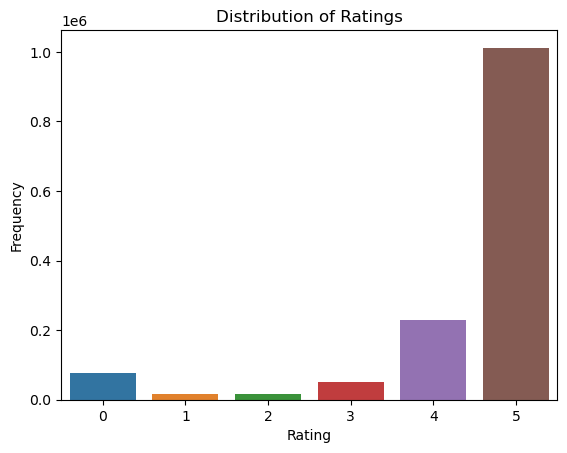

In [11]:
sns.countplot(x='Rating', data=recipe_reviews_df)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

A high number of high ratings indicate a tendency among users to rate only recipes they really like.

Plot demonstrates user engagement level for both casual and power users.

In [13]:
# Calculating descriptive statistics
desc_stats = recipe_reviews_df['Rating'].describe()
print(desc_stats)

# Calculate skewness
skewness = recipe_reviews_df['Rating'].skew()
print(f"Skewness: {skewness}")

count    1.401963e+06
mean     4.407949e+00
std      1.272013e+00
min      0.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64
Skewness: -2.556723435253358


-2.9 skewness indicates that the distribution is negatively skewed. Also, shows the mean is less than the median, and the bulk of the data is concentrated to the right.

### Number of Ratings per Recipe
Identify how frequently each recipe is rated, which can indicate recipe popularity.

C:\Users\bplse\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


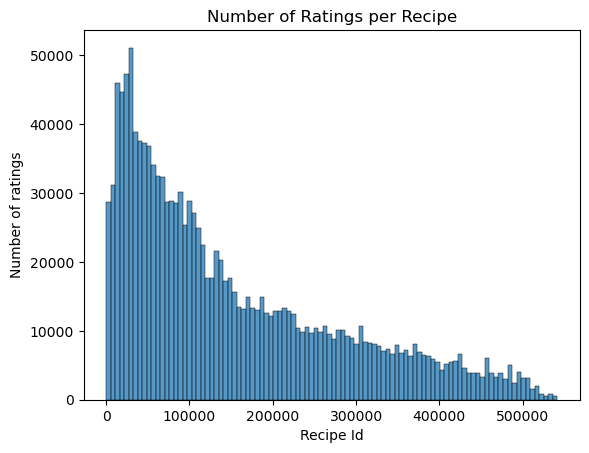

In [15]:
# Plot ratings count per recipe

sns.histplot(recipe_reviews_df['RecipeId'], bins=100, kde=False)
plt.title('Number of Ratings per Recipe')
plt.xlabel('Recipe Id')
plt.ylabel('Number of ratings')
plt.show()

Above plot shows some of the recipes with very few ratings indicating the problem of "sparsity" in the dataset. Sparse data can lead to challenges in accurately predicting user preferences and can skew the results of data-driven models. This we will handle by removing recipes that have below a certain threshold number of ratings to ensure that the data used in analysis and model training is robust.

### Correlation

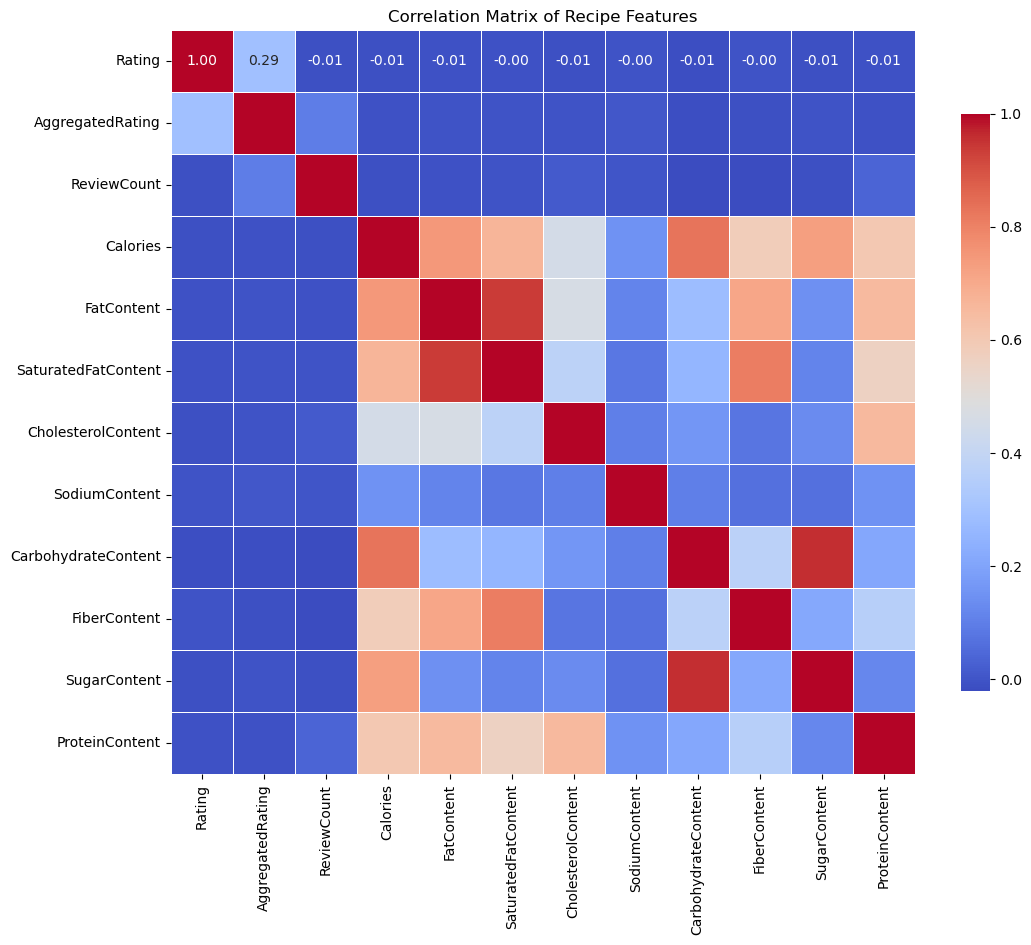

In [16]:
correlation_matrix =recipe_reviews_df.drop(columns=['AuthorId', 'RecipeId', 'Name', 'TotalTime', 'RecipeIngredientParts']).corr()
# Set up the matplotlib figure
plt.figure(figsize=(12, 10))
# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .75}, linewidths=.5)
plt.title('Correlation Matrix of Recipe Features')
plt.show()

In [ ]:
'''# Calculating means and standard deviations
plots = ['Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent',
         'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent',
         'ProteinContent']
for p in plots:
    
    mean_content = small_recipe_reviews_df.groupby('Rating')[p].mean()
    std_content = small_recipe_reviews_df.groupby('Rating')[p].std()
    
    # Bar plot
    plt.figure(figsize=(10, 6))
    mean_content.plot(kind='bar', yerr=std_content, capsize=4)
    plt.title(f'Average {p} Content by Rating with Standard Deviation')
    plt.xlabel('Rating')
    plt.ylabel(f'Average {p} Content')
    plt.show()'''


### Methodologies Implementation 

1. Recommend recipes that similar users have liked or rated highly. 